In [9]:
import os
import zipfile
import numpy as np
from osgeo import gdal, ogr
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Define dataset paths in Kaggle ---
geophysical_dir = '/kaggle/input/random-forest-copper'  # Replace with your geophysical dataset name
copper_dir = '/kaggle/input/label-random-forest'  # Replace with your copper dataset name

print("Strating now....")
# --- Locate feature files ---
feature_files = {
    'TMI': None,
    'Cauchy_VRTP': None,
    'AS_VRTP': None,
    '1VD_VRTP': None
}
feature_files['TMI'] = '/kaggle/input/random-forest-copper/SA_TMI_ERS_GDA2020/SA_TMI.ers'
feature_files['Cauchy_VRTP'] = '/kaggle/input/random-forest-copper/SA_TMI_VRTP_CAUCHY_3rd_ERS_GDA2020/SA_TMI_VRTP_CAUCHY_3rd.ers'
feature_files['AS_VRTP'] = '/kaggle/input/random-forest-copper/SA_TMI_VRTP_AS_TIF_GDA2020/SA_TMI_VRTP_AS.tif'
feature_files['1VD_VRTP'] = '/kaggle/input/random-forest-copper/SA_TMI_VRTP_1VD_ERS_GDA2020/SA_TMI_VRTP_1VD.ers'

# --- Load features ---
features = []
for key, path in feature_files.items():
    dataset = gdal.Open(path)
    band = dataset.GetRasterBand(1).ReadAsArray()
    band = np.where(np.isnan(band), 0, band)  # Replace NaN with 0
    features.append(band)
    print(f"{key} shape: {band.shape}")

Strating now....
TMI shape: (16684, 17719)
Cauchy_VRTP shape: (16712, 17754)


Warning 1: /kaggle/input/random-forest-copper/SA_TMI_VRTP_AS_TIF_GDA2020/SA_TMI_VRTP_AS.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


AS_VRTP shape: (16344, 15440)
1VD_VRTP shape: (16684, 17719)


In [10]:
reference_file = feature_files['TMI']
ref_dataset = gdal.Open(reference_file)
ref_gt = ref_dataset.GetGeoTransform()
ref_proj = ref_dataset.GetProjection()
ref_width = ref_dataset.RasterXSize
ref_height = ref_dataset.RasterYSize
min_x = ref_gt[0]
max_y = ref_gt[3]
max_x = ref_gt[0] + ref_gt[1] * ref_width
min_y = ref_gt[3] + ref_gt[5] * ref_height
output_bounds = (min_x, min_y, max_x, max_y)

print(ref_gt)
print(ref_height)
print(ref_width)
print("ref_proj:", repr(ref_proj))

if not ref_proj:
    ref_proj = 'EPSG:4326'  # Change to appropriate EPSG if needed

resampled_files = {}
for key, path in feature_files.items():
    if key == 'TMI':
        resampled_files[key] = path
    else:
        input_ds = gdal.Open(path)
        if input_ds is None:
            print(f"Failed to open dataset for {key}")
            continue

        output_path = f'/kaggle/working/resampled_{key.lower()}.tif'
        warp_opts = gdal.WarpOptions(
            dstSRS=ref_proj,
            outputBounds=output_bounds,
            xRes=ref_gt[1],
            yRes=abs(ref_gt[5]),
            resampleAlg='bilinear',
            width=ref_width,
            height=ref_height
        )
        gdal.Warp(destNameOrDestDS=output_path, srcDSOrSrcDSTab=input_ds, options=warp_opts)
        resampled_files[key] = output_path
        print(f"Resampled {key} to {output_path}")



(128.11108472611, 0.000777777777778, 0.0, -25.848003242298333, 0.0, -0.000777777777778)
16684
17719
ref_proj: ''
Resampled Cauchy_VRTP to /kaggle/working/resampled_cauchy_vrtp.tif


Warning 1: /kaggle/input/random-forest-copper/SA_TMI_VRTP_AS_TIF_GDA2020/SA_TMI_VRTP_AS.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: /kaggle/input/random-forest-copper/SA_TMI_VRTP_AS_TIF_GDA2020/SA_TMI_VRTP_AS.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Resampled AS_VRTP to /kaggle/working/resampled_as_vrtp.tif
Resampled 1VD_VRTP to /kaggle/working/resampled_1vd_vrtp.tif


In [3]:
features = []
for key, path in resampled_files.items():
    dataset = gdal.Open(path)
    band = dataset.GetRasterBand(1).ReadAsArray()
    band = np.where(np.isnan(band), 0, band)  # Replace NaN with 0
    features.append(band)
    print(f"{key} shape: {band.shape}")

TMI shape: (16684, 17719)
Cauchy_VRTP shape: (16684, 17719)
AS_VRTP shape: (16684, 17719)
1VD_VRTP shape: (16684, 17719)


In [4]:
shapes = [f.shape for f in features]

print(shapes)
# Stack features
training_stacked = np.stack(features, axis=-1)  # Shape: (height, width, 4)
print("Training stacked shape:", training_stacked.shape)

# --- Locate and rasterize SARIG Copper shapefile ---
shp_file = None
for file in os.listdir(copper_dir):
    if file.endswith('.shp'):
        shp_file = os.path.join(copper_dir, file)
        break
if not shp_file:
    raise FileNotFoundError("No .shp file found in copper dataset")


[(16684, 17719), (16684, 17719), (16684, 17719), (16684, 17719)]
Training stacked shape: (16684, 17719, 4)


In [5]:
shp_file = None
for file in os.listdir(copper_dir):
    if file.endswith('.shp'):
        shp_file = os.path.join(copper_dir, file)
        break
if not shp_file:
    raise FileNotFoundError("No .shp file found in copper dataset")

label_file = '/kaggle/working/copper_labels.tif'
driver = ogr.GetDriverByName('ESRI Shapefile')
shp_ds = driver.Open(shp_file)
if shp_ds is None:
    raise FileNotFoundError(f"Could not open SHP file: {shp_file}")
layer = shp_ds.GetLayer()

# Check SHP attributes
layer_defn = layer.GetLayerDefn()
print("SHP attributes:", [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())])

SHP attributes: ['MINERAL_DE', 'DEPOSIT_NA', 'COMMODITY_', 'CONTAINED_', 'CONTAINE01', 'EASTING', 'NORTHING', 'ZONE', 'LONGITUDE', 'LATITUDE', 'RESOURCE_D', 'RESOURCE_T', 'RESOURCE_C', 'COMMODIT02', 'GRADE_CUT_', 'GRADE_AVER', 'GRADE_UNIT', 'ORE_RESOUR', 'ORE_RESO03', 'REFERENCE']


Label mask shape: (16684, 17719)


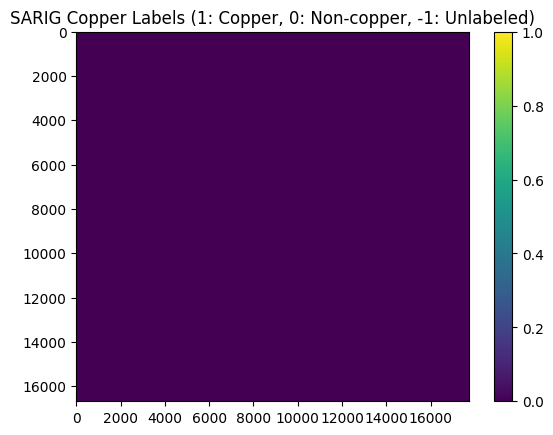

In [6]:
driver = gdal.GetDriverByName('GTiff')
label_dataset = driver.Create(
    label_file,
    training_stacked.shape[1],  # Width
    training_stacked.shape[0],  # Height
    1,
    gdal.GDT_Int16
)
label_dataset.SetGeoTransform(ref_gt)
label_dataset.SetProjection(ref_dataset.GetProjection())
label_band = label_dataset.GetRasterBand(1)
label_band.SetNoDataValue(-1)
label_band.Fill(0)  # Initialize with -1

# Rasterize copper deposits
layer.SetAttributeFilter("COMMODITY_ = 'Cu'")

gdal.RasterizeLayer(
    label_dataset,
    [1],
    layer,
    burn_values=[1]  
)
label_dataset.FlushCache()

# Load label mask
label_mask = label_dataset.GetRasterBand(1).ReadAsArray().astype(np.int16)
print("Label mask shape:", label_mask.shape)

# Verify label mask shape
if label_mask.shape != training_stacked.shape[:2]:
    raise ValueError("Label mask dimensions must match training data")

# Visualize label mask
plt.imshow(label_mask, cmap='viridis')
plt.title('SARIG Copper Labels (1: Copper, 0: Non-copper, -1: Unlabeled)')
plt.colorbar()
plt.show()

In [11]:
print("Copper features:", layer.GetFeatureCount())
print("Extent:", layer.GetExtent())


Copper features: 59
Extent: (135.12345800044034, 140.93801010002971, -35.0918474999433, -29.29871630002367)


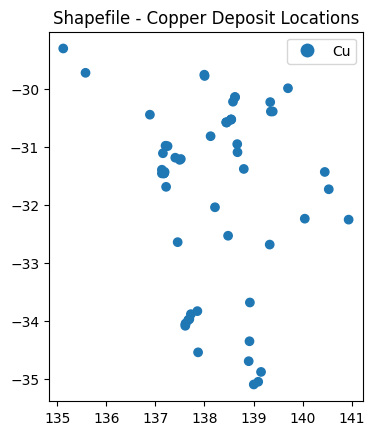

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt

gdf = gpd.read_file(shp_file)
gdf.plot(column="COMMODITY_", legend=True)
plt.title("Shapefile - Copper Deposit Locations")
plt.show()


In [34]:
unique, counts = np.unique(label_mask, return_counts=True)
print("Raster values and counts:", dict(zip(unique, counts)))


Raster values and counts: {0: 295623737, 1: 59}


In [7]:
flat_features = training_stacked.reshape(-1, training_stacked.shape[-1])  # Shape: (n_pixels, 4)
print(flat_features)
flat_labels = label_mask.flatten()

# Select labeled pixels
labeled_mask = flat_labels != 0
X = flat_features[labeled_mask]
y = flat_labels[labeled_mask]
print(f'Training samples: {len(y)}')

# Normalize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {len(y_train)}, Validation samples: {len(y_val)}")

[[-99999. -99999.      0. -99999.]
 [-99999. -99999.      0. -99999.]
 [-99999. -99999.      0. -99999.]
 ...
 [-99999. -99999.      0. -99999.]
 [-99999. -99999.      0. -99999.]
 [-99999. -99999.      0. -99999.]]
Training samples: 59
Training samples: 47, Validation samples: 12


In [8]:
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# Cross-validation
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print("Cross-validation accuracy: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std() * 2))

# --- Evaluate on validation set ---
y_pred_val = clf.predict(X_val)
print("\nValidation Metrics:")
print("Accuracy:", accuracy_score(y_val, y_pred_val))
print("Precision:", precision_score(y_val, y_pred_val))
print("Recall:", recall_score(y_val, y_pred_val))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))

Cross-validation accuracy: 1.00 (+/- 0.00)

Validation Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Confusion Matrix:
 [[12]]


In [16]:
# --- Test on South Australian withheld region ---
test_mask = np.zeros_like(label_mask, dtype=bool)
test_mask[int(label_mask.shape[0]/2):, int(label_mask.shape[1]/2):] = True
training_mask = ~test_mask

# Train on unmasked region
flat_features_train = flat_features[training_mask.flatten()]
flat_labels_train = flat_labels[training_mask.flatten()]
X_train = flat_features_train[flat_labels_train != 0]
y_train = flat_labels_train[flat_labels_train != 0]
X_train = scaler.fit_transform(X_train)
clf.fit(X_train, y_train)

# Test on masked region
flat_features_test = flat_features[test_mask.flatten()]
flat_labels_test = flat_labels[test_mask.flatten()]
test_labeled_mask = flat_labels_test != 0
X_test = flat_features_test[test_labeled_mask]
y_test_true = flat_labels_test[test_labeled_mask]
X_test = scaler.transform(X_test)
y_test_pred = clf.predict(X_test)

In [17]:
print("\nTest Metrics (South Australian withheld region):")
print("Accuracy:", accuracy_score(y_test_true, y_test_pred))
print("Precision:", precision_score(y_test_true, y_test_pred))
print("Recall:", recall_score(y_test_true, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_true, y_test_pred))


Test Metrics (South Australian withheld region):
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
Confusion Matrix:
 [[17]]


In [ ]:
flat_test = flat_features_test
flat_test = scaler.transform(flat_test)
y_pred = clf.predict(flat_test)
pred_map = np.full(label_mask.shape, -1, dtype=np.int16)
pred_map[test_mask] = y_pred.reshape(test_mask.sum())



# Visualize predictions
plt.imshow(pred_map, cmap='viridis')
plt.title('Predicted Copper Deposits (1: Copper, 0: Non-copper, -1: Unpredicted)')
plt.colorbar()
plt.show()

In [ ]:
# Save prediction
driver = gdal.GetDriverByName('GTiff')
out_dataset = driver.Create(
    '/kaggle/working/prediction.tif',
    training_stacked.shape[1],
    training_stacked.shape[0],
    1,
    gdal.GDT_Int16
)
out_dataset.SetGeoTransform(ref_gt)
out_dataset.SetProjection(ref_dataset.GetProjection())
out_dataset.GetRasterBand(1).WriteArray(pred_map)
out_dataset.FlushCache()
print("Prediction saved as /kaggle/working/prediction.tif")

Found TMI: /kaggle/input/random-forest-copper/SA_TMI_ERS_GDA2020/SA_TMI.ers
Found Cauchy_VRTP: /kaggle/working/resampled_cauchy_vrtp.tif
Found AS_VRTP: /kaggle/working/resampled_as_vrtp.tif
Found 1VD_VRTP: /kaggle/working/resampled_1vd_vrtp.tif
Reference GeoTransform: (128.11108472611, 0.000777777777778, 0.0, -25.848003242298333, 0.0, -0.000777777777778)
Reference Height: 16684
Reference Width: 17719
Reference Projection: ''
TMI shape: (16684, 17719)
Cauchy_VRTP shape: (16684, 17719)
AS_VRTP shape: (16684, 17719)
1VD_VRTP shape: (16684, 17719)
Feature shapes: [(16684, 17719), (16684, 17719), (16684, 17719), (16684, 17719)]
Training stacked shape: (16684, 17719, 4)
SHP attributes: ['MINERAL_DE', 'DEPOSIT_NA', 'COMMODITY_', 'CONTAINED_', 'CONTAINE01', 'EASTING', 'NORTHING', 'ZONE', 'LONGITUDE', 'LATITUDE', 'RESOURCE_D', 'RESOURCE_T', 'RESOURCE_C', 'COMMODIT02', 'GRADE_CUT_', 'GRADE_AVER', 'GRADE_UNIT', 'ORE_RESOUR', 'ORE_RESO03', 'REFERENCE']
Label mask shape: (16684, 17719)


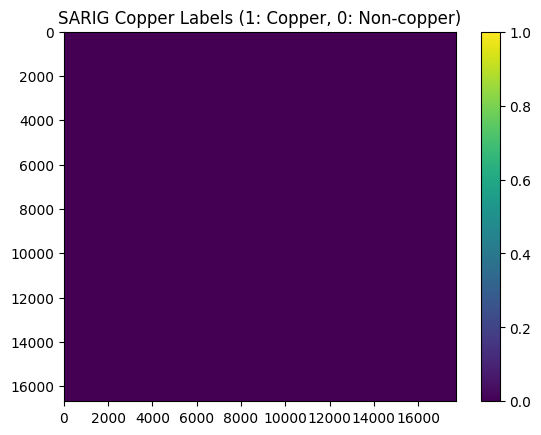

In [14]:
import os
import numpy as np
from osgeo import gdal, ogr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# --- Define parameters ---
batch_size = 100000  # Number of pixels per batch
num_epochs = 5  # Number of passes over the data

# --- Define dataset paths in Kaggle ---
geophysical_dir = '/kaggle/input/random-forest-copper'  # Your geophysical dataset
copper_dir = '/kaggle/input/label-random-forest'  # Your copper dataset
working_dir = '/kaggle/working'  # Directory with resampled GeoTIFFs

# --- Locate resampled feature files ---
feature_files = {
    'TMI': "/kaggle/input/random-forest-copper/SA_TMI_ERS_GDA2020/SA_TMI.ers",
    'Cauchy_VRTP': os.path.join(working_dir, 'resampled_cauchy_vrtp.tif'),
    'AS_VRTP': os.path.join(working_dir, 'resampled_as_vrtp.tif'),
    '1VD_VRTP': os.path.join(working_dir, 'resampled_1vd_vrtp.tif')
}

# Verify resampled files exist
for key, path in feature_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Resampled file not found: {path}")
    print(f"Found {key}: {path}")

# --- Load reference geotransform and projection ---
reference_file = feature_files['TMI']
ref_dataset = gdal.Open(reference_file)
ref_gt = ref_dataset.GetGeoTransform()
ref_proj = ref_dataset.GetProjection()
ref_width = ref_dataset.RasterXSize
ref_height = ref_dataset.RasterYSize

print("Reference GeoTransform:", ref_gt)
print("Reference Height:", ref_height)
print("Reference Width:", ref_width)
print("Reference Projection:", repr(ref_proj))

if not ref_proj:
    ref_proj = 'EPSG:4326'  # Fallback projection

# --- Load features ---
features = []
for key, path in feature_files.items():
    dataset = gdal.Open(path)
    band = dataset.GetRasterBand(1).ReadAsArray()
    band = np.where(np.isnan(band), 0, band)  # Replace NaN with 0
    features.append(band)
    print(f"{key} shape: {band.shape}")

# Verify shapes
shapes = [f.shape for f in features]
print("Feature shapes:", shapes)
if len(set(shapes)) > 1:
    raise ValueError("Feature shapes mismatched. All resampled files must have the same dimensions")

# Stack features
training_stacked = np.stack(features, axis=-1)  # Shape: (height, width, 4)
print("Training stacked shape:", training_stacked.shape)

# --- Locate and rasterize SARIG Copper shapefile ---
shp_file = None
for file in os.listdir(copper_dir):
    if file.endswith('.shp'):
        shp_file = os.path.join(copper_dir, file)
        break
if not shp_file:
    raise FileNotFoundError("No .shp file found in copper dataset")

label_file = '/kaggle/working/copper_labels.tif'
driver = ogr.GetDriverByName('ESRI Shapefile')
shp_ds = driver.Open(shp_file)
if shp_ds is None:
    raise FileNotFoundError(f"Could not open SHP file: {shp_file}")
layer = shp_ds.GetLayer()

# Check SHP attributes
layer_defn = layer.GetLayerDefn()
print("SHP attributes:", [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())])

# Filter for copper deposits
layer.SetAttributeFilter("COMMODITY_ = 'Cu'")

# Create raster for labels
driver = gdal.GetDriverByName('GTiff')
label_dataset = driver.Create(
    label_file,
    ref_width,  # Width
    ref_height,  # Height
    1,
    gdal.GDT_Int16
)
label_dataset.SetGeoTransform(ref_gt)
label_dataset.SetProjection(ref_proj)
label_band = label_dataset.GetRasterBand(1)
label_band.SetNoDataValue(0)  # Use 0 for non-copper
label_band.Fill(0)  # Initialize with 0 (non-copper)

# Rasterize copper deposits
gdal.RasterizeLayer(
    label_dataset,
    [1],
    layer,
    burn_values=[1]  # 1 for copper
)
label_dataset.FlushCache()

# Load label mask
label_mask = label_dataset.GetRasterBand(1).ReadAsArray().astype(np.int16)
print("Label mask shape:", label_mask.shape)

# Verify label mask shape
if label_mask.shape != training_stacked.shape[:2]:
    raise ValueError("Label mask dimensions must match training data")

# Visualize label mask
plt.imshow(label_mask, cmap='viridis')
plt.title('SARIG Copper Labels (1: Copper, 0: Non-copper)')
plt.colorbar()
plt.show()

Found TMI: /kaggle/input/random-forest-copper/SA_TMI_ERS_GDA2020/SA_TMI.ers
Found Cauchy_VRTP: /kaggle/working/resampled_cauchy_vrtp.tif
Found AS_VRTP: /kaggle/working/resampled_as_vrtp.tif
Found 1VD_VRTP: /kaggle/working/resampled_1vd_vrtp.tif
Reference GeoTransform: (128.11108472611, 0.000777777777778, 0.0, -25.848003242298333, 0.0, -0.000777777777778)
Reference Height: 16684
Reference Width: 17719
Reference Projection: ''
TMI shape: (16684, 17719)
Cauchy_VRTP shape: (16684, 17719)
AS_VRTP shape: (16684, 17719)
1VD_VRTP shape: (16684, 17719)
Feature shapes: [(16684, 17719), (16684, 17719), (16684, 17719), (16684, 17719)]
Training stacked shape: (16684, 17719, 4)
SHP attributes: ['MINERAL_DE', 'DEPOSIT_NA', 'COMMODITY_', 'CONTAINED_', 'CONTAINE01', 'EASTING', 'NORTHING', 'ZONE', 'LONGITUDE', 'LATITUDE', 'RESOURCE_D', 'RESOURCE_T', 'RESOURCE_C', 'COMMODIT02', 'GRADE_CUT_', 'GRADE_AVER', 'GRADE_UNIT', 'ORE_RESOUR', 'ORE_RESO03', 'REFERENCE']
Label mask shape: (16684, 17719)


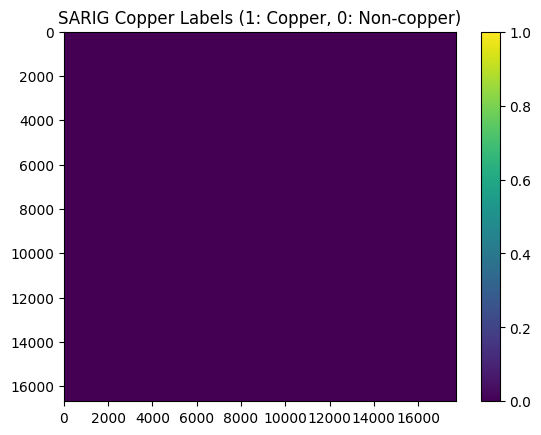

In [2]:
import os
import numpy as np
from osgeo import gdal, ogr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tqdm import tqdm



# --- Define dataset paths in Kaggle ---
geophysical_dir = '/kaggle/input/random-forest-copper'  # Your geophysical dataset
copper_dir = '/kaggle/input/label-random-forest'  # Your copper dataset
working_dir = '/kaggle/working'  # Directory with resampled GeoTIFFs

# --- Locate resampled feature files ---
feature_files = {
    'TMI': "/kaggle/input/random-forest-copper/SA_TMI_ERS_GDA2020/SA_TMI.ers",
    'Cauchy_VRTP': os.path.join(working_dir, 'resampled_cauchy_vrtp.tif'),
    'AS_VRTP': os.path.join(working_dir, 'resampled_as_vrtp.tif'),
    '1VD_VRTP': os.path.join(working_dir, 'resampled_1vd_vrtp.tif')
}

# Verify resampled files exist
for key, path in feature_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Resampled file not found: {path}")
    print(f"Found {key}: {path}")

# --- Load reference geotransform and projection ---
reference_file = feature_files['TMI']
ref_dataset = gdal.Open(reference_file)
ref_gt = ref_dataset.GetGeoTransform()
ref_proj = ref_dataset.GetProjection()
ref_width = ref_dataset.RasterXSize
ref_height = ref_dataset.RasterYSize

print("Reference GeoTransform:", ref_gt)
print("Reference Height:", ref_height)
print("Reference Width:", ref_width)
print("Reference Projection:", repr(ref_proj))

if not ref_proj:
    ref_proj = 'EPSG:4326'  # Fallback projection

# --- Load features ---
features = []
for key, path in feature_files.items():
    dataset = gdal.Open(path)
    band = dataset.GetRasterBand(1).ReadAsArray()
    band = np.where(np.isnan(band), 0, band)  # Replace NaN with 0
    features.append(band)
    print(f"{key} shape: {band.shape}")

# Verify shapes
shapes = [f.shape for f in features]
print("Feature shapes:", shapes)
if len(set(shapes)) > 1:
    raise ValueError("Feature shapes mismatched. All resampled files must have the same dimensions")

# Stack features
training_stacked = np.stack(features, axis=-1)  # Shape: (height, width, 4)
print("Training stacked shape:", training_stacked.shape)

# --- Locate and rasterize SARIG Copper shapefile ---
shp_file = None
for file in os.listdir(copper_dir):
    if file.endswith('.shp'):
        shp_file = os.path.join(copper_dir, file)
        break
if not shp_file:
    raise FileNotFoundError("No .shp file found in copper dataset")

label_file = '/kaggle/working/copper_labels.tif'
driver = ogr.GetDriverByName('ESRI Shapefile')
shp_ds = driver.Open(shp_file)
if shp_ds is None:
    raise FileNotFoundError(f"Could not open SHP file: {shp_file}")
layer = shp_ds.GetLayer()

# Check SHP attributes
layer_defn = layer.GetLayerDefn()
print("SHP attributes:", [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())])

# Filter for copper deposits
layer.SetAttributeFilter("COMMODITY_ = 'Cu'")

# Create raster for labels
driver = gdal.GetDriverByName('GTiff')
label_dataset = driver.Create(
    label_file,
    ref_width,  # Width
    ref_height,  # Height
    1,
    gdal.GDT_Int16
)
label_dataset.SetGeoTransform(ref_gt)
label_dataset.SetProjection(ref_proj)
label_band = label_dataset.GetRasterBand(1)
label_band.SetNoDataValue(0)  # Use 0 for non-copper
label_band.Fill(0)  # Initialize with 0 (non-copper)

# Rasterize copper deposits
gdal.RasterizeLayer(
    label_dataset,
    [1],
    layer,
    burn_values=[1]  # 1 for copper
)
label_dataset.FlushCache()

# Load label mask
label_mask = label_dataset.GetRasterBand(1).ReadAsArray().astype(np.int16)
print("Label mask shape:", label_mask.shape)

# Verify label mask shape
if label_mask.shape != training_stacked.shape[:2]:
    raise ValueError("Label mask dimensions must match training data")

# Visualize label mask
plt.imshow(label_mask, cmap='viridis')
plt.title('SARIG Copper Labels (1: Copper, 0: Non-copper)')
plt.colorbar()
plt.show()



----------------------------------------------------------------------------------------------------------------------------
<h1>FULL CODE OF MODEL: </h1>

In [1]:
import os
import numpy as np
from osgeo import gdal, ogr
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

# --- Define dataset paths in Kaggle ---
geophysical_dir = '/kaggle/input/random-forest-copper'  # Your geophysical dataset
copper_dir = '/kaggle/input/label-random-forest'  # Your copper dataset
working_dir = '/kaggle/working'  # Directory with resampled GeoTIFFs

# --- Locate resampled feature files ---
feature_files = {
    'TMI': "/kaggle/input/random-forest-copper/SA_TMI_ERS_GDA2020/SA_TMI.ers",
    'Cauchy_VRTP': os.path.join(working_dir, 'resampled_cauchy_vrtp.tif'),
    'AS_VRTP': os.path.join(working_dir, 'resampled_as_vrtp.tif'),
    '1VD_VRTP': os.path.join(working_dir, 'resampled_1vd_vrtp.tif')
}

# Verify resampled files exist
for key, path in feature_files.items():
    if not os.path.exists(path):
        raise FileNotFoundError(f"Resampled file not found: {path}")
    print(f"Found {key}: {path}")

# --- Load reference geotransform and projection ---
reference_file = feature_files['TMI']
ref_dataset = gdal.Open(reference_file)
ref_gt = ref_dataset.GetGeoTransform()
ref_proj = ref_dataset.GetProjection()
ref_width = ref_dataset.RasterXSize
ref_height = ref_dataset.RasterYSize

print("Reference GeoTransform:", ref_gt)
print("Reference Height:", ref_height)
print("Reference Width:", ref_width)
print("Reference Projection:", repr(ref_proj))

if not ref_proj:
    ref_proj = 'EPSG:4326'  # Fallback projection

# --- Load features ---
features = []
for key, path in feature_files.items():
    dataset = gdal.Open(path)
    band = dataset.GetRasterBand(1).ReadAsArray()
    band = np.where(np.isnan(band), 0, band)  # Replace NaN with 0
    features.append(band)
    print(f"{key} shape: {band.shape}")

# Verify shapes
shapes = [f.shape for f in features]
print("Feature shapes:", shapes)
if len(set(shapes)) > 1:
    raise ValueError("Feature shapes mismatched. All resampled files must have the same dimensions")

# Stack features
training_stacked = np.stack(features, axis=-1)  # Shape: (height, width, 4)
print("Training stacked shape:", training_stacked.shape)

# --- Locate and rasterize SARIG Copper shapefile ---
shp_file = None
for file in os.listdir(copper_dir):
    if file.endswith('.shp'):
        shp_file = os.path.join(copper_dir, file)
        break
if not shp_file:
    raise FileNotFoundError("No .shp file found in copper dataset")

label_file = '/kaggle/working/copper_labels.tif'
driver = ogr.GetDriverByName('ESRI Shapefile')
shp_ds = driver.Open(shp_file)
if shp_ds is None:
    raise FileNotFoundError(f"Could not open SHP file: {shp_file}")
layer = shp_ds.GetLayer()

# Check SHP attributes
layer_defn = layer.GetLayerDefn()
print("SHP attributes:", [layer_defn.GetFieldDefn(i).GetName() for i in range(layer_defn.GetFieldCount())])

# Filter for copper deposits
layer.SetAttributeFilter("COMMODITY_ = 'Cu'")

# Create raster for labels
driver = gdal.GetDriverByName('GTiff')
label_dataset = driver.Create(
    label_file,
    ref_width,  # Width
    ref_height,  # Height
    1,
    gdal.GDT_Int16
)
label_dataset.SetGeoTransform(ref_gt)
label_dataset.SetProjection(ref_proj)
label_band = label_dataset.GetRasterBand(1)
label_band.SetNoDataValue(0)  # Use 0 for non-copper
label_band.Fill(0)  # Initialize with 0 (non-copper)

# Rasterize copper deposits
gdal.RasterizeLayer(
    label_dataset,
    [1],
    layer,
    burn_values=[1]  # 1 for copper
)
label_dataset.FlushCache()

# Load label mask
label_mask = label_dataset.GetRasterBand(1).ReadAsArray().astype(np.int16)
print("Label mask shape:", label_mask.shape)





Found TMI: /kaggle/input/random-forest-copper/SA_TMI_ERS_GDA2020/SA_TMI.ers
Found Cauchy_VRTP: /kaggle/working/resampled_cauchy_vrtp.tif
Found AS_VRTP: /kaggle/working/resampled_as_vrtp.tif
Found 1VD_VRTP: /kaggle/working/resampled_1vd_vrtp.tif
Reference GeoTransform: (128.11108472611, 0.000777777777778, 0.0, -25.848003242298333, 0.0, -0.000777777777778)
Reference Height: 16684
Reference Width: 17719
Reference Projection: ''
TMI shape: (16684, 17719)
Cauchy_VRTP shape: (16684, 17719)
AS_VRTP shape: (16684, 17719)
1VD_VRTP shape: (16684, 17719)
Feature shapes: [(16684, 17719), (16684, 17719), (16684, 17719), (16684, 17719)]
Training stacked shape: (16684, 17719, 4)
SHP attributes: ['MINERAL_DE', 'DEPOSIT_NA', 'COMMODITY_', 'CONTAINED_', 'CONTAINE01', 'EASTING', 'NORTHING', 'ZONE', 'LONGITUDE', 'LATITUDE', 'RESOURCE_D', 'RESOURCE_T', 'RESOURCE_C', 'COMMODIT02', 'GRADE_CUT_', 'GRADE_AVER', 'GRADE_UNIT', 'ORE_RESOUR', 'ORE_RESO03', 'REFERENCE']
Label mask shape: (16684, 17719)


In [ ]:
# --- Compute class weights ---
classes = np.array([0, 1])
y_labeled = label_mask[np.isin(label_mask, [0, 1])]
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_labeled)
class_weight_dict = dict(zip(classes, weights))
print(f"Class weights: {class_weight_dict}")

# --- Print class distribution ---
unique, counts = np.unique(y_labeled, return_counts=True)
print(f"Class distribution: {dict(zip(unique, counts))}")

# --- Initialize and fit scaler ---
scaler = StandardScaler()
# Flatten training_stacked for scaling
flat_features = training_stacked.reshape(-1, training_stacked.shape[-1])
# Fit scaler only on valid (labeled) pixels
labeled_mask = np.isin(label_mask.flatten(), [0, 1])
scaler.fit(flat_features[labeled_mask])
print("Scaler fitted on labeled pixels")


Class weights: {0: 0.5000000997890098, 1: 2505286.406779661}
Class distribution: {0: 295623737, 1: 59}


In [ ]:
# --- Batch processing function ---
from sklearn.model_selection import train_test_split
def generate_batches(training_stacked, label_mask, batch_size, max_batches=None):
    height, width = label_mask.shape
    num_features = training_stacked.shape[-1]
    batch_count = 0
    
    for start_row in range(0, height, 100):
        end_row = min(start_row + 100, height)
        chunk_stacked = training_stacked[start_row:end_row, :, :]
        chunk_label = label_mask[start_row:end_row, :]
        
        flat_features = chunk_stacked.reshape(-1, num_features)
        flat_labels = chunk_label.flatten()
        
        labeled_mask = np.isin(flat_labels, [0, 1])
        if np.any(labeled_mask):
            X_chunk = flat_features[labeled_mask]
            y_chunk = flat_labels[labeled_mask]
            
            for i in range(0, len(X_chunk), batch_size):
                if max_batches is not None and batch_count >= max_batches:
                    return  # Stop yielding batches
                end_idx = min(i + batch_size, len(X_chunk))
                yield X_chunk[i:end_idx], y_chunk[i:end_idx]
                batch_count += 1

# --- Define batch_size and epochs ---
batch_size = 10000  # Matches your estimation
num_epochs = 1

# --- Estimate number of batches per epoch ---
total_pixels = ref_height * ref_width
labeled_fraction = 0.1
approx_labeled_pixels = total_pixels * labeled_fraction
approx_batches = int(np.ceil(approx_labeled_pixels / batch_size))
print(f"Estimated batches per epoch: {approx_batches}")

# --- Calculate actual labeled pixels and batches ---
actual_labeled_pixels = np.sum(np.isin(label_mask, [0, 1]))
actual_batches = int(np.ceil(actual_labeled_pixels / batch_size))
print(f"Actual labeled pixels: {actual_labeled_pixels}, Actual batches: {actual_batches}")

# --- Create validation set ---
flat_features = training_stacked.reshape(-1, training_stacked.shape[-1])
flat_labels = label_mask.flatten()
labeled_mask = np.isin(flat_labels, [0, 1])
X_labeled = flat_features[labeled_mask]
y_labeled = flat_labels[labeled_mask]
X_train, X_val, y_train, y_val = train_test_split(
    X_labeled, y_labeled, test_size=0.2, random_state=42, stratify=y_labeled
)
print(f"Training samples: {len(X_train)}, Validation samples: {len(X_val)}")

# --- Initialize model ---
clf = RandomForestClassifier(n_estimators=50, random_state=42, class_weight=class_weight_dict)

# --- Train with batches and epochs ---
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    clf.n_estimators = 50 + (epoch * 10)  # Set trees per epoch
    with tqdm(total=approx_batches, desc=f"Processing Epoch {epoch + 1}", unit="batch") as pbar:
        for batch_idx, (X_batch, y_batch) in enumerate(generate_batches(training_stacked, label_mask, batch_size, max_batches=approx_batches)):
            if len(X_batch) == 0:
                pbar.update(1)
                continue
            X_batch = scaler.transform(X_batch)  # Scale features
            clf.fit(X_batch, y_batch)
            pbar.update(1)
    
    # Validation
    X_val_scaled = scaler.transform(X_val)
    y_pred_val = clf.predict(X_val_scaled)
    print(f"\nValidation Metrics (Epoch {epoch + 1}):")
    print("Accuracy:", accuracy_score(y_val, y_pred_val))
    print("Precision:", precision_score(y_val, y_pred_val, zero_division=0))
    print("Recall:", recall_score(y_val, y_pred_val, zero_division=0))
    print("ROC AUC:", roc_auc_score(y_val, y_pred_val))
    print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_val))


Estimated batches per epoch: 2957
Actual labeled pixels: 295623796, Actual batches: 29563


In [ ]:
# --- Optional: Predict on file.tif ---
input_tif = '/path/to/file.tif'  # Update with your GeoTIFF path
with rasterio.open(input_tif) as src:
    raster_data = src.read()  # Shape: (num_bands, 4712, 5943)
    profile = src.profile
    height, width = src.shape
    num_bands = src.count

# Transpose to (height, width, num_bands)
raster_data = np.transpose(raster_data, (1, 2, 0))  # Shape: (4712, 5943, num_bands)

# Validate bands
if num_bands != training_stacked.shape[-1]:
    raise ValueError(f"Band mismatch: file.tif has {num_bands}, training has {training_stacked.shape[-1]}")

# Handle NoData
nodata = profile.get('nodata', None)
valid_mask = np.all(raster_data != nodata, axis=2) if nodata is not None else np.ones((height, width), dtype=bool)

# Flatten and predict
flat_data = raster_data.reshape(-1, num_bands)
flat_valid_mask = valid_mask.flatten()
X_pred = flat_data[flat_valid_mask]
X_pred_scaled = scaler.transform(X_pred)
y_pred = clf.predict(X_pred_scaled)

# Create prediction map
pred_flat = np.zeros(flat_data.shape[0], dtype=np.int16)
pred_flat[flat_valid_mask] = y_pred
pred_map = pred_flat.reshape(height, width)

# Save prediction
output_profile = profile.copy()
output_profile.update({'count': 1, 'dtype': 'int16', 'nodata': None})
with rasterio.open('/kaggle/working/prediction.tif', 'w', **output_profile) as dst:
    dst.write(pred_map, 1)
print("Prediction saved as /kaggle/working/prediction.tif")

# Visualize
plt.imshow(pred_map, cmap='viridis')
plt.title('Predicted Copper Deposits (1: Copper, 0: Non-copper)')
plt.colorbar(label='Prediction')
plt.show()